**Assignment**: Designing and Tuning a Convolutional Neural Network (CNN)

**Assignment Description**: There are four parts to this assignment

1.   Building a CNN
2.   Training and Tuning a CNN
3.   Trying Out a New Dataset
4.   Open-Ended Exploration

You will be largely guided through the first two parts. The third and fourth part are discussion based questions.

**Before the experiment, make sure that you have GPU enabled. This setting can be found under *Tools --> Settings***

In [26]:
#Install Objax
!pip --quiet install  objax
import objax

In [27]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import jax.numpy as jn
import random
import matplotlib.pyplot as plt

##**Part 1. Building a CNN**

Before we build our CNN model, let's first import a dataset. For our experiment, we load the CIFAR10 dataset from Tensorflow's dataset repository. The CIFAR10 dataset consists of 60,000 32x32 colour images in 10 classes, with 6000 images per class. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks.

After loading the dataset, we split the dataset into training, validation and test set. The dataset is originally stored as 50,000 training examples and 10,000 test examples. Instead, we will combine them together and make our own split.

Do not change split ratio for now.

In [28]:
#.load_data() by default returns a split between training and test set.
# We then adjust the training set into a format that can be accepted by our CNN
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train.transpose(0, 3, 1, 2) / 255.0
Y_train = Y_train.flatten()
X_test = X_test.transpose(0, 3, 1, 2) / 255.0
Y_test = Y_test.flatten()

np.random.seed(1)
# To create a validation set, we first concate the original splitted dataset into a single dataset
# then randomly shuffle the images and labels in the same way (seed = 1)
X_data = np.concatenate([X_train, X_test], axis = 0)
Y_data = np.concatenate([Y_train, Y_test], axis = 0)

N = np.arange(len(X_data))
np.random.shuffle(N)
X_data = X_data[N]
Y_data = Y_data[N]

#Next, we partition the randomly shuffled dataset into training, validation and testset according a ratio
train_ratio = 0.80
valid_ratio = 0.1
n_train = int(len(X_data) * train_ratio)
n_valid = int(len(X_data) * valid_ratio)

X_train, X_valid, X_test = X_data[:n_train], X_data[n_train:n_train+n_valid], X_data[n_train+n_valid:]
Y_train, Y_valid, Y_test = Y_data[:n_train], Y_data[n_train:n_train+n_valid], Y_data[n_train+n_valid:]


Next we will construct a **Base Model**, which in our case is a small CNN.

In [29]:
class ConvNet(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)

    x = x.mean((2,3)) #<--- global average pooling
    x = self.linear(x)
    return x

#The following line creates the CNN
model = ConvNet()
#You can examine the architecture of our CNN by calling model.vars()
model.vars()

{'(ConvNet).conv_1(Sequential)[0](Conv2D).b': objax.TrainVar(Array([[[0.]],
        [[0.]],
        [[0.]],
        [[0.]],
        [[0.]],
        [[0.]],
        [[0.]],
        [[0.]],
        [[0.]],
        [[0.]],
        [[0.]],
        [[0.]],
        [[0.]],
        [[0.]],
        [[0.]],
        [[0.]]], dtype=float32), reduce=reduce_mean),
 '(ConvNet).conv_1(Sequential)[0](Conv2D).w': objax.TrainVar(Array([[[[ 0.5138634 ,  0.21371605, -0.29575428, -0.33510804,
            0.5342783 ,  0.6840026 , -0.21211353, -0.18958087,
            0.02446042, -0.6532474 , -0.24305594, -0.1549251 ,
            0.19649696,  0.0567767 , -0.34387165, -0.68971914],
          [-0.5512079 , -0.00514014, -0.25653327,  0.08227336,
            0.43916818,  0.02070774,  0.52119106,  0.11159535,
            0.386511  ,  0.00894886, -0.10542095,  0.22239149,
           -0.08560332,  0.17372546, -0.47705224,  0.49459025],
          [ 0.11827198,  0.3743364 , -0.16209342, -0.14755452,
           -0.280

Before we train our conv net, let's try to better understand concepts of convolution filter and linear layer. In the following, you will take the first very image of the training set, create a simple convolution routine, and show that our own routine matches what Objax returns.



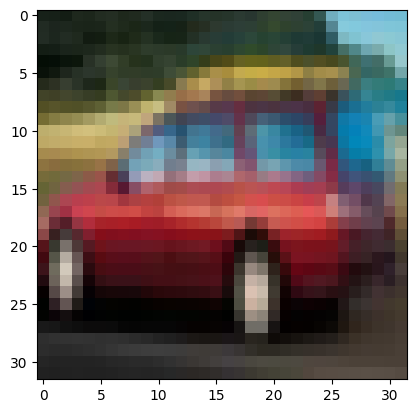

In [30]:
#Let's plot the first image in the training set.
plt.imshow(X_train[0].transpose(1,2,0))

Next, we will pass our image through Objax's convolution routine. Carefully examine the following code and try to understand the dimension of the filter weights and the output.

In [31]:
# We append the first image with a batch size of 1 so it can be fed into a convolution layer
my_image = np.expand_dims(X_train[0], 0)

#Consider a very simple CNN filter with stride = 1 and no padding ('VALID').
Conv2d = objax.nn.Conv2D(nin = 3, nout = 2, k = 1, strides = 1, padding = 'VALID', use_bias = False)

filter_weights = Conv2d.w.value #This is the initial weight of the filter, which we gradually update when training, we ignore bias for now

print("Filter weights:", filter_weights)
print("Conv output:", Conv2d(my_image))
print("Conv output shape:", np.shape(Conv2d(my_image)))

Filter weights: [[[[-0.589181   -0.3933312 ]
   [-0.22490506 -0.252498  ]
   [ 0.18868007  0.04591646]]]]
Conv output: [[[[-0.06374913 -0.06129656 -0.05467876 ... -0.27729207 -0.27317816
    -0.2730874 ]
   [-0.08827486 -0.07513001 -0.07920448 ... -0.31424254 -0.30736232
    -0.30490974]
   [-0.09072743 -0.07601199 -0.09146735 ... -0.35298657 -0.342316
    -0.33199862]
   ...
   [-0.1079132  -0.10300805 -0.10300805 ... -0.17446621 -0.17691879
    -0.1842765 ]
   [-0.09074519 -0.08584004 -0.08584004 ... -0.18918166 -0.18672909
    -0.18672909]
   [-0.0809349  -0.07848233 -0.0809349  ... -0.22351766 -0.22106509
    -0.21370737]]

  [[-0.06365154 -0.06129893 -0.0544212  ... -0.32972354 -0.32500625
    -0.32400396]
   [-0.08717752 -0.07442433 -0.07794719 ... -0.3568871  -0.3520675
    -0.3497149 ]
   [-0.08953013 -0.07541452 -0.08971019 ... -0.38216048 -0.3754383
    -0.36766025]
   ...
   [-0.10351436 -0.09880916 -0.09880916 ... -0.15584868 -0.15820128
    -0.16525908]
   [-0.08704616 -0.

**In the cells below, you will create your own convolution routine that takes in the image and the initial weights used by Objax's own convolution routine (Conv2d.w.value) and show that your convolution routine returns the same value than Objax's.**

A simple implementation only requires 4 FOR loops. You may wish to draw inspiration from https://objax.readthedocs.io/en/latest/objax/nn.html?highlight=objax.nn.Conv2D#objax.nn.Conv2D

In [32]:
#Solution to the above problem
print(f'Image Dimensions: {my_image.shape}')
print(f'Filter Dimensions: {filter_weights.shape}')
print(f'Output Dimensions: {np.shape(Conv2d(my_image))}')

def my_conv_net(my_image, initial_filter_weights):
  # Defining I/O & Filter Dimensions
  N, C_in, H, W = my_image.shape
  k, k, C_in, C_out = initial_filter_weights.shape
  H_out = H - k + 1
  W_out = W - k + 1

  # Creating output array
  my_conv_output = np.zeros((N, C_out, H_out, W_out))
  for h in range(0,H_out):
    for w in range(0,W_out):
      for c in range(0, C_out):
        temp = 0
        for t in range(0, C_in):
            temp += my_image[0, t, 0+h, 0+w] * initial_filter_weights[0,0,t,c]
        my_conv_output[0,c,h,w] = temp


  return my_conv_output

# Storing outputs
my_conv_output = my_conv_net(my_image, filter_weights)
objax_conv = Conv2d(my_image)

# Printing my output
print(my_conv_output)

Image Dimensions: (1, 3, 32, 32)
Filter Dimensions: (1, 1, 3, 2)
Output Dimensions: (1, 2, 32, 32)
[[[[-0.06374913 -0.06129656 -0.05467876 ... -0.27729207 -0.27317816
    -0.27308738]
   [-0.08827486 -0.07513001 -0.07920448 ... -0.31424254 -0.30736232
    -0.30490977]
   [-0.09072743 -0.07601199 -0.09146735 ... -0.35298657 -0.34231603
    -0.33199859]
   ...
   [-0.1079132  -0.10300805 -0.10300805 ... -0.17446621 -0.17691879
    -0.18427651]
   [-0.09074519 -0.08584005 -0.08584005 ... -0.18918166 -0.18672909
    -0.18672909]
   [-0.08093489 -0.07848233 -0.08093489 ... -0.22351766 -0.22106509
    -0.21370737]]

  [[-0.06365153 -0.06129893 -0.0544212  ... -0.32972354 -0.32500625
    -0.32400396]
   [-0.08717752 -0.07442434 -0.07794718 ... -0.3568871  -0.35206753
    -0.34971491]
   [-0.08953012 -0.07541452 -0.08971018 ... -0.38216048 -0.3754383
    -0.36766025]
   ...
   [-0.10351436 -0.09880917 -0.09880917 ... -0.15584868 -0.15820128
    -0.16525908]
   [-0.08704617 -0.08234097 -0.08234

In [33]:
# Checking if outputs are equal (allowed tolerance = 10^-20)
if np.allclose(my_conv_output, objax_conv, atol=1e-5):
  print('Same output')
else:
  print("Not same")

Same output


The outputs of last convolution layer is typically rearranged so it can be fed into a linear layer. Check that calling .mean((2,3)) rearranges the output of your convolution routine by examining the shape of the output. (Not graded) Think about alternative ways of rearranging the output from the convolution layer.

In [34]:
# Original output shape
print(f'Output shape: {my_conv_output.shape}')

#Check that .mean((2,3)) rearranges your image
conv_mean = my_conv_output.mean((2,3))
print(f'After .mean((2,3)): {conv_mean.shape}')

# Taking the mean flattens the input along specified axes
print(f'Mean flattens given axies & leaves remaining')


Output shape: (1, 2, 32, 32)
After .mean((2,3)): (1, 2)
Mean flattens given axies & leaves remaining


Take your rearranged output and feed it into a linear layer of appropriate size. Here is an example:

```
Linear_Layer = objax.nn.Linear(N, 1)
Y = Linear_Layer(X)
```
Next, extract the weights and bias of the linear layer using
```
Linear_Layer.w.value
Linear_Layer.b.value
```
**Using these values, write one line of code that manually implements the linear layer. Show that it provides the same value as Objax's own linear layer.**



In [35]:
# Computing Objax's linear layer
Linear_Layer = objax.nn.Linear(32,1)
Y = Linear_Layer(my_conv_output)
objax_w = Linear_Layer.w
objax_b = Linear_Layer.b

In [36]:
# Printing results
print(f'Input shape: {my_conv_output.shape}')
print(f'Output shape: {Y.shape}')
print(f'Linear_Layer w: \n{objax_w.value}, shape={objax_w.shape}')
print(f'Linear_Layer b: {objax_b.value}, shape={objax_b.shape}')

# Manual implementation
out = objax_b[0] + np.matmul(my_conv_output, objax_w)
print(f'\nManual output: \n{out}')
print(f'\nLinear_Layer output: \n{Y}')

# Checking if outputs are equal (allowed tolerance = 10^-20)
if np.allclose(out, Y, atol=1e-5):
  print('\nSame output')
else:
  print("\nNot same")

Input shape: (1, 2, 32, 32)
Output shape: (1, 2, 32, 1)
Linear_Layer w: 
[[-2.2403303e-01]
 [ 3.3494413e-01]
 [-3.0916870e-01]
 [ 5.9580382e-02]
 [-4.9970755e-01]
 [-4.0153834e-01]
 [-2.9446749e-02]
 [ 6.4307086e-02]
 [-4.0104315e-01]
 [-1.9857702e-01]
 [-3.1291766e-04]
 [-3.3877248e-01]
 [-3.4908596e-01]
 [ 2.5610578e-01]
 [ 2.5654611e-01]
 [-1.5124432e-02]
 [ 3.7272477e-01]
 [-1.9352798e-01]
 [ 3.4586880e-01]
 [-5.0959673e-02]
 [ 1.4468713e-01]
 [ 1.8839693e-01]
 [-7.7738836e-02]
 [ 4.0229224e-02]
 [ 7.6033734e-02]
 [-9.1012657e-02]
 [ 2.6813287e-01]
 [-4.6868610e-01]
 [-2.3829874e-01]
 [ 4.9346443e-03]
 [-4.8089272e-01]
 [ 4.5179775e-01]], shape=(32, 1)
Linear_Layer b: [0.], shape=(1,)

Manual output: 
[[[[ 0.20003009]
   [ 0.1766398 ]
   [ 0.19484368]
   [ 0.19479299]
   [ 0.01524057]
   [-0.24484503]
   [-0.13261692]
   [ 0.2387187 ]
   [ 0.55322677]
   [ 0.7414506 ]
   [ 0.69232106]
   [ 0.6276504 ]
   [ 0.5237435 ]
   [ 0.30741954]
   [ 0.3254838 ]
   [ 0.39521292]
   [ 0.473022

You have now completed Part 1 of the assignment. Good job!


In [37]:
# Finding sizes of train, test, and validation sets
print(f'Number of training samples: {X_train.shape[0]}')
print(f'Number of validation samples: {X_valid.shape[0]}')
print(f'Number of testing samples: {X_test.shape[0]}')
print(f'\nNumber iterations per epoch (batchsize = 32): {int(X_train.shape[0]/32)}')
print(f'Number iterations for 30 epochs (batchsize=32): {int(X_train.shape[0]/32)*30}')

Number of training samples: 48000
Number of validation samples: 6000
Number of testing samples: 6000

Number iterations per epoch (batchsize = 32): 1500
Number iterations for 30 epochs (batchsize=32): 45000


## Handout Questions (Part 1)

1. (1 point) Your data has been split into training, validation and test set. Examine the ratio of the split and number of examples in each set. Suppose you were to train on batches of 32 examples each. That is, in each step of gradient descent, you randomly select 32 examples from the training set, compute your average loss on these examples, and then compute the gradient of this average loss with respect to the model parameters.

Q1a: How many iterations will it take to go through the entire training set given the number of training examples yielded by the data split?

> One epoch is equivalent to iterating through each datapoint within the training set once. Each iteration looks at 32 new examples and the training set has size 48000, thus there are 1500 iterations per epoch with a batchsize of 32.

Q1b: How many iterations are there in 30 epochs? Recall that one epoch is the number of iterations needed to train over the entire dataset.

> Since there are 1500 iterations per epoch, 30 epochs would consist of 45000 iterations.

2. (2 points) Fill in the code for your custom convolution filter and show that it returns the same output as Objax’s own convolution routine.
>See above.

3. (1 point) Fill in the code for your linear layer, and show that it returns the same output as passing through Objax’s own linear layer.
>See above.

4. (1 point) Explain in a short paragraph what is the difference between the training and validation set.
>The training set is used to fine the optimal parameters (ie weights for neural networks), while the validation set is used to tune the model's hyperparameters. Having these two sets is important because hyperparameter tuning using the training set may increase the chance of memorization and thus reduces the model's ability to generalize. Likewise, performing hyperparameter tuning on the test set is "cheating" and not indicitive of a real test result since the model will be able to "learn" see the answer.

##**Part 2. Training and Tuning a CNN**

The following starter code trains the neural network in Part 1. However, the optimizer and batch sampling routine are left for you to implement. Complete the lines that says #PUT YOUR CODE HERE#

Afterwards, train the model, and observe the training/validation loss and accuracy plots. You should observe that the validation accuracy is low and stagnates after a few epochs.

In [38]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model(x)), model.vars())

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      params.value = params.value - lr*grad #PUT YOUR CODE HERE#
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

In [39]:
def train(EPOCHS = 20, BATCH = 32, LEARNING_RATE = 9e-4):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation
      train_indices = np.arange(len(X_train))
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it: it+BATCH] #PUT YOUR CODE HERE#
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid))
      np.random.shuffle(val_indices)
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it: it+BATCH] #PUT YOUR CODE HERE#
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))

  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

In [40]:
print(X_train.shape)

(48000, 3, 32, 32)


Epoch 0001  Training Loss 2.33 Validation Loss 2.30 Training Accuracy 10.20 Validation Accuracy 11.50
Epoch 0002  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 13.26 Validation Accuracy 15.77
Epoch 0003  Training Loss 2.30 Validation Loss 2.29 Training Accuracy 16.18 Validation Accuracy 16.52
Epoch 0004  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 16.31 Validation Accuracy 16.47
Epoch 0005  Training Loss 2.29 Validation Loss 2.28 Training Accuracy 16.34 Validation Accuracy 16.55
Epoch 0006  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 16.18 Validation Accuracy 16.68
Epoch 0007  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 16.47 Validation Accuracy 16.60
Epoch 0008  Training Loss 2.27 Validation Loss 2.27 Training Accuracy 16.54 Validation Accuracy 17.45
Epoch 0009  Training Loss 2.27 Validation Loss 2.26 Training Accuracy 17.09 Validation Accuracy 17.58
Epoch 0010  Training Loss 2.26 Validation Loss 2.26 Training Accuracy 17.25 Valida

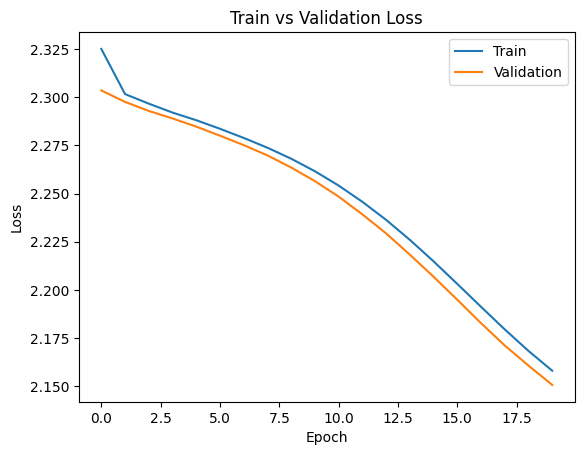

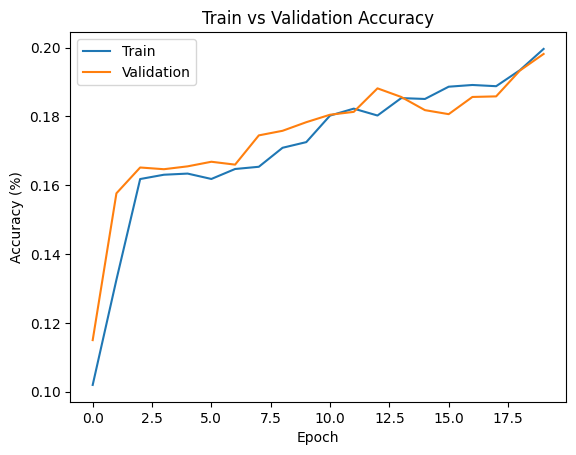

In [41]:
train()

Follow the assignment handout for questions to be answered in this part of the assignment.

## Handout Questions (Part 2)

1. (1 point) Complete the optimizer by using the definition of (stochastic) gradient descent. Note that you need to update params.value, which are the values of the trainable variables of your model.
>See above.

2. (1 point) Complete the batch sampling code in the train function by specifying a batch of examples. You should make use the lists train indices and val indices.
>See above.

3. (1 point) Train the model for a few epochs, and observe the training/validation loss and training/validation accuracy plots. Include these plots within the PDF you hand in. You should observe that the validation accuracy is low and stagnates after a few epochs. Next we will go through a rudimentary way of adjusting the hyperparameters of the model which we created.
>See above.

4. (1 point) In one sentence, define the meaning of a “hyperparameter”. Explain in a short paragraph why it is important not to evaluate the accuracy on the test set until all hyperparameters have been tuned.
>Hyperparameters are model parameters which are not updated during training, and instead are set before training. It is important to not evaluate accuracy on the test set until all hyperparameters have been tuned in order to have a more authentic test case, where the test data is completely novel to the model. This is to say that by evaluating testing accuracy and then using this information to update the hyperparameters the model is "cheating" by knowing the answer even though the test data is supposed to represent an input that is completely unknown to the model. Thus instead of memorizing the training data the model is able to "memorize" the testing data.  

5. (2 points) Select 4 hyperparameters associated with your network, one of the hyperparameter must involve your CNN architecture, and come up with two different sets of hyperparameters.
For example, suppose my set of hyperparameters are defined as (yours might be different) H = {batch size, learning rate, number of outputs of conv layer 1, number of conv layers}, where conv layer is defined as a composition between filter, activation and pooling, then two sets of hyperparameters may be,
H1 = {32, 0.001, 16, 2} H2 = {64, 0.0001, 32, 3}. The hyperparameters that you tune does not need to be specified as a numerical value. For instance, you can specify the optimizer you are using to train the network, or the activation function you are using. You may wish to consult: https://objax.readthedocs.io/en/latest/notebooks/Custom_Networks.html
> Let the set of hyperparameters be denoted by H and contain: H = {number conv layers, activation, learning rate, batch size}. Let H1 = {2, tanh, 0.01, 100} and H2 = {3, relu, 0.1, 16}. We are allowed to specify batch size and learning rate for Adam since the Adam optimizer uses both in its algorithm. Two of the selected hyperparameters involve the CNN architecture, which are the optimizer and activation functions.

In [42]:
# Question 6: Creating 2 additional networks

# M1: number conv layers = 2, activation = tanh
class M1(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.tanh])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.tanh])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)

    x = x.mean((2,3)) # global average pooling
    x = self.linear(x)
    return x

# M2: number conv layers = 3, activation = relu
class M2(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.relu])
    self.conv_3 = objax.nn.Sequential([objax.nn.Conv2D(32, 32, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = objax.functional.max_pool_2d(self.conv_2(x), 2, 2)
    x = self.conv_3(x)

    x = x.mean((2,3)) # global average pooling
    x = self.linear(x)
    return x

# Create 2 CNNs from M1 & M2
M1_model = M1()
M2_model = M2()

In [43]:
#Define loss function as averaged value of of cross entropies
def loss_function_M1(x, labels):
    logit = M1_model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

def loss_function_M2(x, labels):
    logit = M2_model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict_M1 = objax.Jit(lambda x: objax.functional.softmax(M1_model(x)), M1_model.vars())
predict_M2 = objax.Jit(lambda x: objax.functional.softmax(M2_model(x)), M2_model.vars())

#Create an object that can be used to calculate the gradient and value of loss_function
gv_M1 = objax.GradValues(loss_function_M1, M1_model.vars())
gv_M2 = objax.GradValues(loss_function_M2, M2_model.vars())

#Create an object that can be used to provide trainable variables in the model
tv_M1 = objax.ModuleList(objax.TrainRef(x) for x in M1_model.vars().subset(objax.TrainVar))
tv_M2 = objax.ModuleList(objax.TrainRef(x) for x in M2_model.vars().subset(objax.TrainVar))

#Training routine
def train_op_M1(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv_M1(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv_M1.vars()):
      params.value = params.value - lr*grad
    return loss_value                      # return loss value

def train_op_M2(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv_M2(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv_M2.vars()):
      params.value = params.value - lr*grad
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op_M1 = objax.Jit(train_op_M1, gv_M1.vars() + tv_M1.vars())
train_op_M2 = objax.Jit(train_op_M2, gv_M2.vars() + tv_M2.vars())

In [44]:
# M1 Training: learning rate = 0.01, batch size = 100
def train_model_M1(EPOCHS = 20, BATCH = 100, LEARNING_RATE = 0.01):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation
      train_indices = np.arange(len(X_train))
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it: it+BATCH] #PUT YOUR CODE HERE#
          avg_train_loss += float(train_op_M1(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict_M1(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid))
      np.random.shuffle(val_indices)
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it: it+BATCH] #PUT YOUR CODE HERE#
          avg_val_loss += float(loss_function_M1(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict_M1(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('M1: Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))

  #Plot training loss
  plt.title("Train vs Validation Loss (M1)")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy (M1)")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

In [45]:
# M2 training: learning rate = 0.1, batch size = 16
def train_model_M2(EPOCHS = 20, BATCH = 16, LEARNING_RATE = 0.1):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation
      train_indices = np.arange(len(X_train))
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it: it+BATCH] #PUT YOUR CODE HERE#
          avg_train_loss += float(train_op_M2(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict_M2(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid))
      np.random.shuffle(val_indices)
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it: it+BATCH] #PUT YOUR CODE HERE#
          avg_val_loss += float(loss_function_M2(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict_M2(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('M2: Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))

  #Plot training loss
  plt.title("Train vs Validation Loss (M2)")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy (M2)")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

M1: Epoch 0001  Training Loss 2.30 Validation Loss 2.28 Training Accuracy 14.72 Validation Accuracy 15.40
M1: Epoch 0002  Training Loss 2.26 Validation Loss 2.24 Training Accuracy 16.80 Validation Accuracy 17.38
M1: Epoch 0003  Training Loss 2.22 Validation Loss 2.20 Training Accuracy 19.52 Validation Accuracy 20.22
M1: Epoch 0004  Training Loss 2.18 Validation Loss 2.16 Training Accuracy 21.20 Validation Accuracy 21.00
M1: Epoch 0005  Training Loss 2.14 Validation Loss 2.12 Training Accuracy 21.89 Validation Accuracy 22.42
M1: Epoch 0006  Training Loss 2.12 Validation Loss 2.11 Training Accuracy 22.61 Validation Accuracy 21.80
M1: Epoch 0007  Training Loss 2.10 Validation Loss 2.09 Training Accuracy 22.86 Validation Accuracy 22.20
M1: Epoch 0008  Training Loss 2.09 Validation Loss 2.08 Training Accuracy 23.26 Validation Accuracy 22.70
M1: Epoch 0009  Training Loss 2.08 Validation Loss 2.07 Training Accuracy 23.72 Validation Accuracy 23.13
M1: Epoch 0010  Training Loss 2.07 Validation 

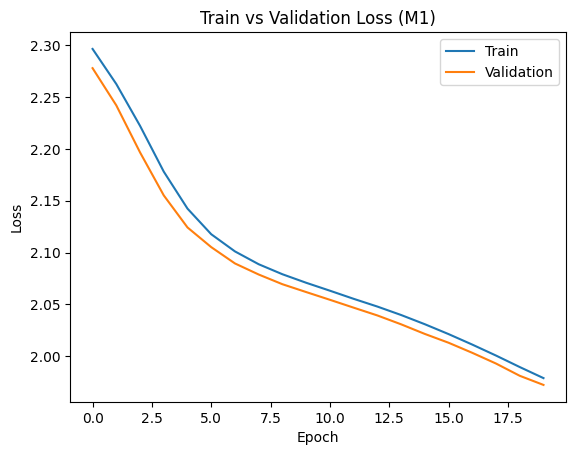

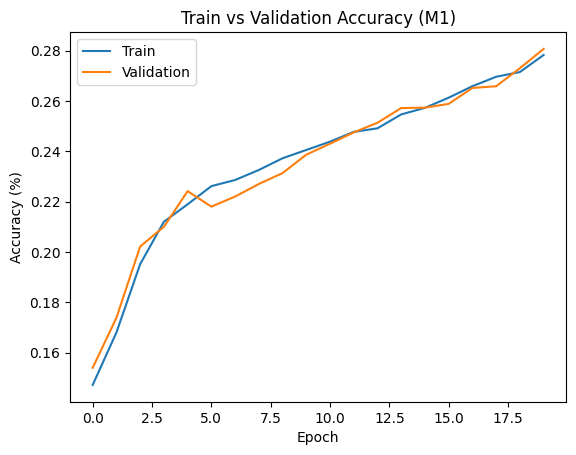

In [46]:
train_model_M1()

M2: Epoch 0001  Training Loss 1.97 Validation Loss 1.73 Training Accuracy 36.27 Validation Accuracy 34.30
M2: Epoch 0002  Training Loss 1.63 Validation Loss 1.71 Training Accuracy 52.13 Validation Accuracy 36.03
M2: Epoch 0003  Training Loss 1.51 Validation Loss 1.49 Training Accuracy 57.03 Validation Accuracy 47.67
M2: Epoch 0004  Training Loss 1.41 Validation Loss 1.35 Training Accuracy 61.26 Validation Accuracy 51.08
M2: Epoch 0005  Training Loss 1.33 Validation Loss 1.26 Training Accuracy 64.79 Validation Accuracy 54.32
M2: Epoch 0006  Training Loss 1.27 Validation Loss 1.25 Training Accuracy 67.71 Validation Accuracy 54.32
M2: Epoch 0007  Training Loss 1.22 Validation Loss 1.21 Training Accuracy 69.78 Validation Accuracy 56.48
M2: Epoch 0008  Training Loss 1.19 Validation Loss 1.15 Training Accuracy 71.12 Validation Accuracy 58.37
M2: Epoch 0009  Training Loss 1.16 Validation Loss 1.16 Training Accuracy 72.27 Validation Accuracy 58.40
M2: Epoch 0010  Training Loss 1.14 Validation 

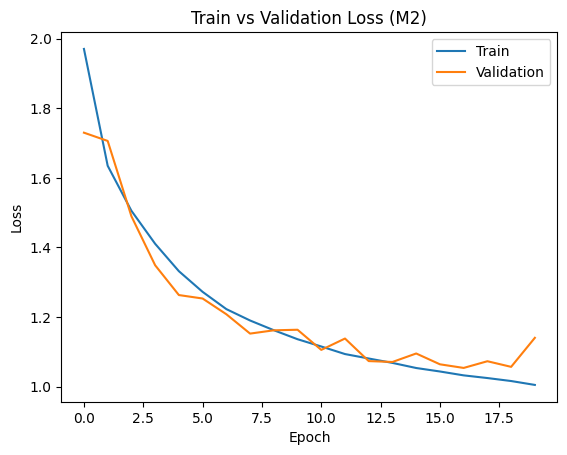

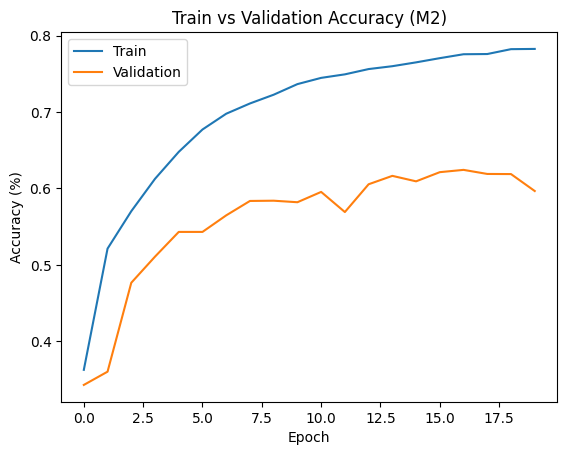

In [47]:
train_model_M2()

## Handout Questions (Part 2) continued...
6. (3 points) Create two additional networks M1, M2, each with the set of hyperparameter H1, H2 that you have selected above. Train each model. Report the best validation accuracy as well as the corresponding epoch for which this occurs for the Base Model and your two additional models. For example,
Base model: 20% at epoch 22 M1: 30% at epoch 18 M2: 50% at epoch 24
Which model performs the best in terms of validation accuracy? These new models do not need to outperform the base model, however, if you are unsatisfied with the validation accuracy, adjust your hyperparameters in the previous part and train until you are satisfied. Don’t forget to report your hyperparameters.

>Best validation accuracy:
>*   Base: 19.82% at epoch 20
*   M1: 28.07% at epoch 20
*   M2: 62.43% at epoch 17

>The model which performs best in terms of validation accuracy is M2 which has hyperparameters H2 = {number conv layers = 3, activation = relu, learning rate = 0.1, batch size = 16}.

>The second best model is M1 where H1 = {number conv layers = 2, activation = tanh, learning rate = 0.01, batch size = 100}.

>The worst validation accuracy came from the base case where H = {number conv layers = 2, activation = relu, learning rate = 9e-4, batch size = 32}.

7. (2 points) Based on your answer, which model should you pick as your final model and why? Then evaluate your model on the test set and report final test accuracy.
>I would choose M2 as my final model since it has highest validation accuracy and does not require significant computation time. On the test set this model outperformed the rest as expected achieving 59.3% test accuracy, compared to M1 at 27.68% and base at 19.37%.

In [48]:
# M2 test accuracy
M2_test_prediction = predict_M2(X_test).argmax(1)
M2_test_acc = (np.array(M2_test_prediction).flatten() == Y_test).sum()
M2_test_accuracy_percentage = 100*M2_test_acc/X_test.shape[0]

# M1 test accuracy
M1_test_prediction = predict_M1(X_test).argmax(1)
M1_test_acc = (np.array(M1_test_prediction).flatten() == Y_test).sum()
M1_test_accuracy_percentage = 100*M1_test_acc/X_test.shape[0]

# Base test accuracy
base_test_prediction = predict(X_test).argmax(1)
base_test_acc = (np.array(base_test_prediction).flatten() == Y_test).sum()
base_test_accuracy_percentage = 100*base_test_acc/X_test.shape[0]

# Printing results
print(f'Base test accuracy: {round(base_test_accuracy_percentage,2)}%')
print(f'M1 test accuracy: {round(M1_test_accuracy_percentage,2)}%')
print(f'M2 test accuracy: {round(M2_test_accuracy_percentage,2)}%')

Base test accuracy: 19.37%
M1 test accuracy: 27.68%
M2 test accuracy: 59.3%


You have now completed Part 2 of the assignment. Good job!


##**Part 3. Trying Out a New Dataset**

To solidify your knowledge of training and tuning of a CNN, you will run another set of experiments on a new dataset. It should closely follow what you have done in Part 2. You will develop your own network to classify the data included in the dataset you picked. You may re-use any part of the starter code (e.g., for dataloading).

Pick a dataset of your own choosing from the following link (under “Image classification”):
https://www.tensorflow.org/datasets/catalog/overview

###Step 1: *(1 point)*
Import and partition your data

In [49]:
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.transpose(0, 1, 2) / 255.0
Y_train = Y_train.flatten()
X_test = X_test.transpose(0, 1, 2) / 255.0
Y_test = Y_test.flatten()

np.random.seed(1)
# To create a validation set, we first concate the original splitted dataset into a single dataset
# then randomly shuffle the images and labels in the same way (seed = 1)
X_data = np.concatenate([X_train, X_test], axis = 0)
Y_data = np.concatenate([Y_train, Y_test], axis = 0)

N = np.arange(len(X_data))
np.random.shuffle(N)
X_data = X_data[N]
Y_data = Y_data[N]

#Next, we partition the randomly shuffled dataset into training, validation and testset according a ratio
train_ratio = 0.80
valid_ratio = 0.1
n_train = int(len(X_data) * train_ratio)
n_valid = int(len(X_data) * valid_ratio)

X_train, X_valid, X_test = X_data[:n_train], X_data[n_train:n_train+n_valid], X_data[n_train+n_valid:]
Y_train, Y_valid, Y_test = Y_data[:n_train], Y_data[n_train:n_train+n_valid], Y_data[n_train+n_valid:]

11490434/11490434 [==============================] - 0s 0us/step


In [50]:
def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

(56000, 1, 28, 28)


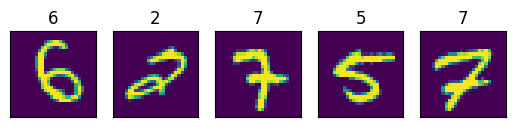

In [51]:
plot_example(X_train, Y_train)

# reshaping X:
X_train = X_train.reshape(-1, 1, 28, 28)
X_test = X_test.reshape(-1, 1, 28, 28)
X_valid = X_valid.reshape(-1, 1, 28, 28)

print(X_train.shape)

###Step 2: *(1 point)*
Create a base model to start out with

In [52]:
# let base model = CNN with 2 convolution layers using 2D batch normalization
class BaseModel(objax.Module):
  '''CNN base model using 2 convolutional layers, activation = relu, pooling = BatchNorm2D'''
  def __init__(self, number_of_channels = 1, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.nn.BatchNorm2D(16), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.nn.BatchNorm2D(32), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x, training):
    x = objax.functional.max_pool_2d(self.conv_1(x, training=training), 2, 2)
    x = self.conv_2(x, training=training)

    x = x.mean((2,3)) # global average pooling
    x = self.linear(x)
    return x

base_model = BaseModel()

In [53]:
#Define loss function as averaged value of of cross entropies
def loss_function_base(x, labels):
    logit = base_model(x, training=True)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict_base = objax.Jit(lambda x: objax.functional.softmax(base_model(x, training=False)), base_model.vars())

#Create an object that can be used to calculate the gradient and value of loss_function
gv_base = objax.GradValues(loss_function_base, base_model.vars())

#Create an object that can be used to provide trainable variables in the model
tv_base = objax.ModuleList(objax.TrainRef(x) for x in base_model.vars().subset(objax.TrainVar))

#Training routine
def train_op_base(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv_base(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv_base.vars()):
      params.value = params.value - lr*grad
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op_base = objax.Jit(train_op_base, gv_base.vars() + tv_base.vars())

In [54]:
# Base Training: learning rate = 0.01, batch size = 100
def train_model_base(EPOCHS = 20, BATCH = 100, LEARNING_RATE = 0.01):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation
      train_indices = np.arange(len(X_train))
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it: it+BATCH] #PUT YOUR CODE HERE#
          avg_train_loss += float(train_op_base(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict_base(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid))
      np.random.shuffle(val_indices)
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it: it+BATCH] #PUT YOUR CODE HERE#
          avg_val_loss += float(loss_function_base(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict_base(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Base: Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))

  #Plot training loss
  plt.title("Train vs Validation Loss (Base)")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy (Base)")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Base: Epoch 0001  Training Loss 2.25 Validation Loss 2.20 Training Accuracy 13.89 Validation Accuracy 18.71
Base: Epoch 0002  Training Loss 2.15 Validation Loss 2.11 Training Accuracy 12.76 Validation Accuracy 10.77
Base: Epoch 0003  Training Loss 2.07 Validation Loss 2.03 Training Accuracy 11.38 Validation Accuracy 10.70
Base: Epoch 0004  Training Loss 1.98 Validation Loss 1.95 Training Accuracy 11.40 Validation Accuracy 10.93
Base: Epoch 0005  Training Loss 1.90 Validation Loss 1.87 Training Accuracy 11.91 Validation Accuracy 12.23
Base: Epoch 0006  Training Loss 1.83 Validation Loss 1.80 Training Accuracy 13.37 Validation Accuracy 14.09
Base: Epoch 0007  Training Loss 1.77 Validation Loss 1.75 Training Accuracy 17.46 Validation Accuracy 19.43
Base: Epoch 0008  Training Loss 1.71 Validation Loss 1.70 Training Accuracy 22.79 Validation Accuracy 23.67
Base: Epoch 0009  Training Loss 1.67 Validation Loss 1.65 Training Accuracy 26.42 Validation Accuracy 26.80
Base: Epoch 0010  Training L

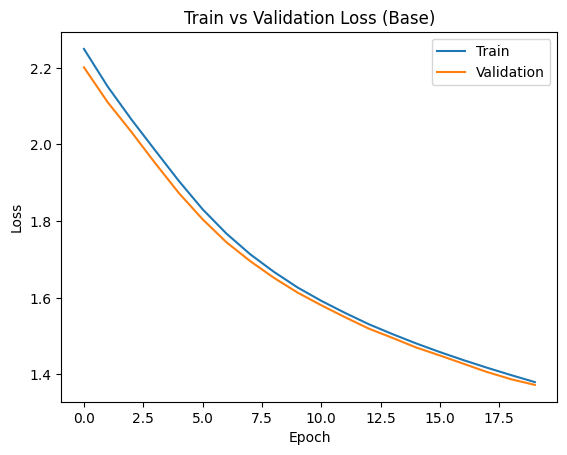

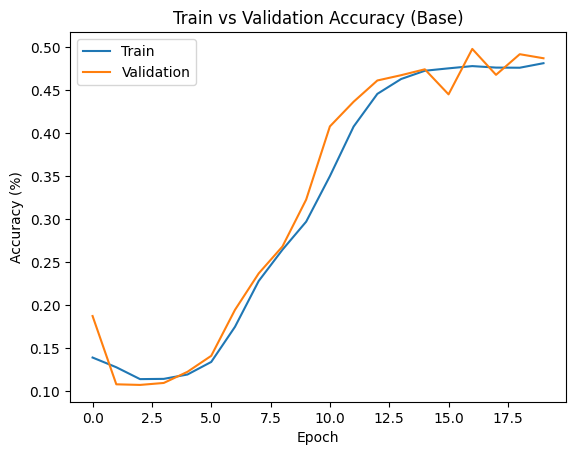

In [55]:
train_model_base()

###Step 3: *(3 points)*
Pick several hyperparameters you would like to tune and train a model until its validation accuracy is 5-10% better than the base model. Provide a succinct discussion on your design procedure: which hyperparameters you tuned, what is the new validation accuracy.
>Both networks have the following layer format: Conv --> BatchNorm2D --> ReLU

> Base: H_b = {num conv layers = 2, learning rate = 0.01, batch size = 100, epochs = 20}

> Tuned: H_t = {num conv layers = 4, learning rate = 0.1, batch size = 16, epochs = 10}

> The maximum validation accuracy increased from 49.79% at epoch 17 for the base model to 99.03% at epoch 8 for the tuned model.

In [56]:
# let tuned model = base model w/ 2 more conv layers, learning rate = 0.1, and batchsize = 16
class TunedModel(objax.Module):
  '''CNN tuned model using 4 convolutional layers, activation = relu, pooling = BatchNorm2D'''
  def __init__(self, number_of_channels = 1, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.nn.BatchNorm2D(16), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.nn.BatchNorm2D(32), objax.functional.relu])
    self.conv_3 = objax.nn.Sequential([objax.nn.Conv2D(32, 32, 2), objax.nn.BatchNorm2D(32), objax.functional.relu])
    self.conv_4 = objax.nn.Sequential([objax.nn.Conv2D(32, 64, 2), objax.nn.BatchNorm2D(64), objax.functional.relu])
    self.linear = objax.nn.Linear(64, number_of_classes)

  def __call__(self, x, training):
    x = objax.functional.max_pool_2d(self.conv_1(x, training=training), 2, 2)
    x = objax.functional.max_pool_2d(self.conv_2(x, training=training), 2, 2)
    x = objax.functional.max_pool_2d(self.conv_3(x, training=training), 2, 2)
    x = self.conv_4(x, training=training)

    x = x.mean((2,3)) # global average pooling
    x = self.linear(x)
    return x

tuned_model = TunedModel()

In [57]:
#Define loss function as averaged value of of cross entropies
def loss_function_tuned(x, labels):
    logit = tuned_model(x, training=True)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict_tuned = objax.Jit(lambda x: objax.functional.softmax(tuned_model(x, training=False)), tuned_model.vars())

#Create an object that can be used to calculate the gradient and value of loss_function
gv_tuned = objax.GradValues(loss_function_tuned, tuned_model.vars())

#Create an object that can be used to provide trainable variables in the model
tv_tuned = objax.ModuleList(objax.TrainRef(x) for x in tuned_model.vars().subset(objax.TrainVar))

#Training routine
def train_op_tuned(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv_tuned(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv_tuned.vars()):
      params.value = params.value - lr*grad
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op_tuned = objax.Jit(train_op_tuned, gv_tuned.vars() + tv_tuned.vars())

In [58]:
# Tuned Training: Epochs = 10, learning rate = 0.1, batch size = 16
def train_model_tuned(EPOCHS = 10, BATCH = 16, LEARNING_RATE = 0.1):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation
      train_indices = np.arange(len(X_train))
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it: it+BATCH] #PUT YOUR CODE HERE#
          avg_train_loss += float(train_op_tuned(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict_tuned(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid))
      np.random.shuffle(val_indices)
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it: it+BATCH] #PUT YOUR CODE HERE#
          avg_val_loss += float(loss_function_tuned(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict_tuned(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Tuned: Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))

  #Plot training loss
  plt.title("Train vs Validation Loss (Tuned)")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy (Tuned)")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Tuned: Epoch 0001  Training Loss 0.20 Validation Loss 0.09 Training Accuracy 53.81 Validation Accuracy 94.41
Tuned: Epoch 0002  Training Loss 0.07 Validation Loss 0.06 Training Accuracy 98.18 Validation Accuracy 96.91
Tuned: Epoch 0003  Training Loss 0.05 Validation Loss 0.05 Training Accuracy 99.14 Validation Accuracy 98.49
Tuned: Epoch 0004  Training Loss 0.04 Validation Loss 0.05 Training Accuracy 98.99 Validation Accuracy 97.53
Tuned: Epoch 0005  Training Loss 0.04 Validation Loss 0.04 Training Accuracy 99.38 Validation Accuracy 98.77
Tuned: Epoch 0006  Training Loss 0.03 Validation Loss 0.05 Training Accuracy 99.46 Validation Accuracy 98.54
Tuned: Epoch 0007  Training Loss 0.03 Validation Loss 0.06 Training Accuracy 99.56 Validation Accuracy 97.70
Tuned: Epoch 0008  Training Loss 0.03 Validation Loss 0.05 Training Accuracy 99.57 Validation Accuracy 99.03
Tuned: Epoch 0009  Training Loss 0.02 Validation Loss 0.04 Training Accuracy 99.56 Validation Accuracy 98.99
Tuned: Epoch 0010  

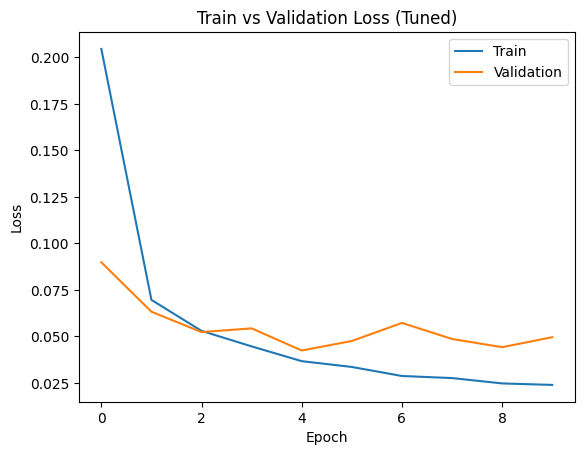

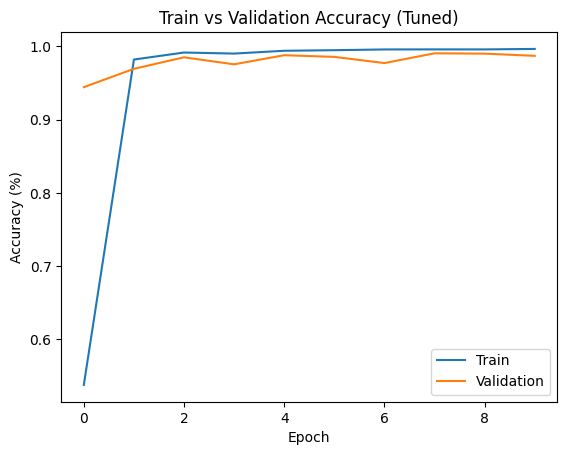

In [59]:
train_model_tuned()


###Step 4: *(1 point)*
Select your final model and report test accuracy.
>I will be selecting my tuned model as my final model, where the test accuracy for the tuned model was 98.99% which is over twice as accurate as the base which had 48.2% test accuracy.

In [60]:
# Base test accuracy
base_test_prediction = predict_base(X_test).argmax(1)
base_test_acc = (np.array(base_test_prediction).flatten() == Y_test).sum()
base_test_accuracy_percentage = 100*base_test_acc/X_test.shape[0]

# Tuned test accuracy
tuned_test_prediction = predict_tuned(X_test).argmax(1)
tuned_test_acc = (np.array(tuned_test_prediction).flatten() == Y_test).sum()
tuned_test_accuracy_percentage = 100*tuned_test_acc/X_test.shape[0]

# Printing results
print(f'Base test accuracy: {round(base_test_accuracy_percentage,2)}%')
print(f'Tuned test accuracy: {round(tuned_test_accuracy_percentage,2)}%')

Base test accuracy: 48.2%
Tuned test accuracy: 98.99%


##**Problem 4. Open-Ended Exploration**

###**Question 3: How do optimizers compare?**
**Part 1) Optimization routine and the rationale behind their implementations, and all hyperparameters associated with each optimizer:**

I decided to implement the Adam and Momentum optimizers from Objax (see below). The momentum optimizer is a modification of SGD which helps accelerate weight updates and avoid oscillations. This is done by introducing a velocity term which is a running average of past gradients, thus the updated weight is a linear combination of the current gradient and past velocities. To be more specific the update rule is:

*   velocity = p * velocity + (1-p) * grad(loss)
*   w = w - learning rate * velocity

Similarly, Adam combines momentum with adaptive learning rates to update the weights based on past gradients. The adaptive learning rate is applied to each individual parameter, and keeps track of their variances. The routine is as follows:

*   mean = decay1 * mean + (1-decay1) * grad(Loss)
*   velocity = decay2*velocity + (1-decay2) * grad(Loss)^2
*   mean_mod = mean / (1-decay1^num_steps)
*   velo_mod = velocity / (1-decay2^num_steps)
*   w = w - learning rate / [sqrt(velo_mod) + epsilon] * mean_mod

Here epsilon is just to prevent dividing by zero. Thus Momentum optimization uses the hyperparameters of learning rate and a momentum term (p), while Adam uses learning rate, epsilon, and two "momentum" terms which I have denoted decay1 and decay2.

**Part 2) Implement them in Objax, then compare their performances on the validation set after some tuning. Report the final performance on the test set.**

 For this part of the assignment used the cifar10 dataset from parts 1&2 while using the same layer architecture from part 3 which is as follows: conv2D --> BatchNorm2D --> ReLU (i.e., conv-bn-relu).

I tuned the following hyperparameters:

Same for Adam & Momentum:
*   Number of conv layers: START=4, END=3
*   Conv layer sizes: START=16->32->32->64, END=16->32->64

Adam:
*   Learning rate: START=0.1, END=0.01
*   Batch size: START=100, END=32

Momentum:
*   Learning rate: START=0.1, END=0.01
*   Batch size: START=100, END=0.01


 I tried a variety of models tuning these different hyperparameters, and also tried removing the BatchNorm2D part of the layer architecture in order to improve performance. However having BatchNorm increased validation accuracy from 40-42% to 70-72% (which is about a 30% increase).

 I chose my final hyperparameter settings by evalutating the tradeoffs between training time and improved accuracy. While having four layers would likely improve prediction accuracy the increase in training time is too significant for my purposes, thus I choose the final architectures which are detailed above and can also be seen in the code below.

I chose the Adam model as my final model since it had the highest validation accuracy at 73.75% compared to base (19.82%), M1 (28.07%), M2 (62.43%), and momentum (72.23%).

This choice was validated by the testing results (see below) which showed that Adam had the best accuracy during testing:

*   Base test accuracy: 19.37%
*   M1 test accuracy: 27.68%
*   M2 test accuracy: 59.3%
*   **Adam test accuracy: 73.2%**
*   Momentum test accuracy: 71.8%

In [61]:
# Using the cifar10 dataset from parts 1&2
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train.transpose(0, 3, 1, 2) / 255.0
Y_train = Y_train.flatten()
X_test = X_test.transpose(0, 3, 1, 2) / 255.0
Y_test = Y_test.flatten()

np.random.seed(1)
# Concatenating & shuffling
X_data = np.concatenate([X_train, X_test], axis = 0)
Y_data = np.concatenate([Y_train, Y_test], axis = 0)

N = np.arange(len(X_data))
np.random.shuffle(N)
X_data = X_data[N]
Y_data = Y_data[N]

# Partitioning into train, test, & validation sets
train_ratio = 0.80
valid_ratio = 0.1
n_train = int(len(X_data) * train_ratio)
n_valid = int(len(X_data) * valid_ratio)

X_train, X_valid, X_test = X_data[:n_train], X_data[n_train:n_train+n_valid], X_data[n_train+n_valid:]
Y_train, Y_valid, Y_test = Y_data[:n_train], Y_data[n_train:n_train+n_valid], Y_data[n_train+n_valid:]

### CNN Using Adam Optimizer:

In [63]:
# Creating 4 layer CNN using ADAM optimizer, setting EMA debias to True
class AdamModel(objax.Module):
  '''CNN Adam model using 4 convolutional layers, activation = relu, pooling = BatchNorm2D'''
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.nn.BatchNorm2D(16), objax.functional.leaky_relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.nn.BatchNorm2D(32), objax.functional.leaky_relu])
    self.conv_3 = objax.nn.Sequential([objax.nn.Conv2D(32, 64, 2), objax.nn.BatchNorm2D(64), objax.functional.leaky_relu])
    self.linear = objax.nn.Linear(64, number_of_classes)

  def __call__(self, x, training):
    x = objax.functional.max_pool_2d(self.conv_1(x, training=training), 2, 2)
    x = objax.functional.max_pool_2d(self.conv_2(x, training=training), 2, 2)
    x = self.conv_3(x, training=training)

    x = x.mean((2,3))
    x = self.linear(x)
    return x

# create instance of adam model, EMA, and adam optimizer
adam_model = AdamModel()
model_ema = objax.optimizer.ExponentialMovingAverageModule(adam_model, debias=True)
adam_opt = objax.optimizer.Adam(adam_model.vars())

In [64]:
# average cross entropy loss
def loss_function_adam(x, labels):
    logit = adam_model(x, training=True)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

# prediction fxn
predict_adam = objax.Jit(lambda x: objax.functional.softmax(model_ema(x, training=False)), model_ema.vars())

# object to find grad of loss
gv_adam = objax.GradValues(loss_function_adam, adam_model.vars())

# training routine
def train_op_adam(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv_adam(x, y)
    adam_opt(lr, gradient)
    model_ema.update_ema()
    return loss_value

# speeding up train_op with JIT compilation
train_op_adam = objax.Jit(train_op_adam, adam_model.vars()+gv_adam.vars()+adam_opt.vars()+model_ema.vars())

In [65]:
# Tuned Training: Epochs = 20, learning rate = 0.01, batch size = 32
def train_model_adam(EPOCHS = 20, BATCH = 32, LEARNING_RATE = 0.01):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation
      train_indices = np.arange(len(X_train))
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it: it+BATCH]
          avg_train_loss += float(train_op_adam(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict_adam(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid))
      np.random.shuffle(val_indices)
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it: it+BATCH]
          avg_val_loss += float(loss_function_adam(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict_adam(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Adam: Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))

  #Plot training loss
  plt.title("Train vs Validation Loss (Adam)")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy (Adam)")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Adam: Epoch 0001  Training Loss 1.47 Validation Loss 1.30 Training Accuracy 18.90 Validation Accuracy 26.60
Adam: Epoch 0002  Training Loss 1.22 Validation Loss 1.16 Training Accuracy 36.12 Validation Accuracy 47.52
Adam: Epoch 0003  Training Loss 1.12 Validation Loss 1.12 Training Accuracy 56.40 Validation Accuracy 59.60
Adam: Epoch 0004  Training Loss 1.05 Validation Loss 1.05 Training Accuracy 62.48 Validation Accuracy 63.47
Adam: Epoch 0005  Training Loss 1.01 Validation Loss 1.00 Training Accuracy 66.33 Validation Accuracy 66.78
Adam: Epoch 0006  Training Loss 0.97 Validation Loss 0.95 Training Accuracy 68.12 Validation Accuracy 67.62
Adam: Epoch 0007  Training Loss 0.94 Validation Loss 0.95 Training Accuracy 69.69 Validation Accuracy 68.83
Adam: Epoch 0008  Training Loss 0.90 Validation Loss 0.94 Training Accuracy 71.97 Validation Accuracy 69.93
Adam: Epoch 0009  Training Loss 0.89 Validation Loss 0.93 Training Accuracy 72.40 Validation Accuracy 69.28
Adam: Epoch 0010  Training L

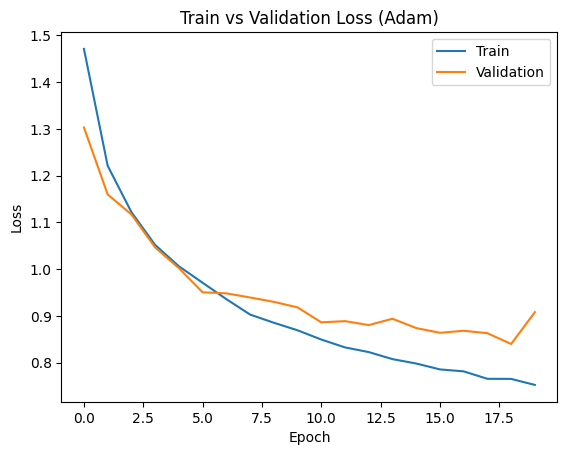

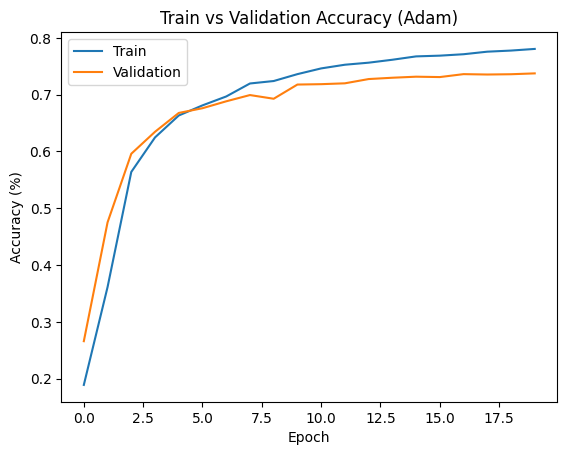

In [66]:
train_model_adam()

### CNN Using Momemtum Optimizer

In [67]:
# Creating 4 layer CNN using MOMENTUM optimizer, setting EMA debias to True
class MomentumModel(objax.Module):
  '''CNN Momentum model using 3 convolutional layers, activation = leaky_relu, pooling = BatchNorm2D'''
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.nn.BatchNorm2D(16), objax.functional.leaky_relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.nn.BatchNorm2D(32), objax.functional.leaky_relu])
    self.conv_3 = objax.nn.Sequential([objax.nn.Conv2D(32, 64, 2), objax.nn.BatchNorm2D(64), objax.functional.leaky_relu])
    self.linear = objax.nn.Linear(64, number_of_classes)

  def __call__(self, x, training):
    x = objax.functional.max_pool_2d(self.conv_1(x, training=training), 2, 2)
    x = objax.functional.max_pool_2d(self.conv_2(x, training=training), 2, 2)
    x = self.conv_3(x, training=training)

    x = x.mean((2,3))
    x = self.linear(x)
    return x

# create instance of adam model, EMA, and adam optimizer
mom_model = MomentumModel()
model_ema_mom = objax.optimizer.ExponentialMovingAverageModule(mom_model, debias=True)
mom_opt = objax.optimizer.Momentum(mom_model.vars())

In [74]:
# average cross entropy loss
def loss_function_mom(x, labels):
    logit = mom_model(x, training=True)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

# prediction fxn
predict_mom = objax.Jit(lambda x: objax.functional.softmax(model_ema_mom(x, training=False)), model_ema_mom.vars())

# object to find grad of loss
gv_mom = objax.GradValues(loss_function_mom, mom_model.vars())

# training routine
def train_op_mom(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv_mom(x, y)
    mom_opt(lr, gradient)
    model_ema_mom.update_ema()
    return loss_value

# speeding up train_op with JIT compilation
train_op_mom = objax.Jit(train_op_mom, mom_model.vars()+gv_mom.vars()+mom_opt.vars()+model_ema_mom.vars())

In [69]:
# Tuned Training: Epochs = 10, learning rate = 0.1, batch size = 16
def train_model_mom(EPOCHS = 20, BATCH = 32, LEARNING_RATE = 0.01):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation
      train_indices = np.arange(len(X_train))
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it: it+BATCH]
          avg_train_loss += float(train_op_mom(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict_mom(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid))
      np.random.shuffle(val_indices)
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it: it+BATCH]
          avg_val_loss += float(loss_function_mom(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict_mom(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Momentum: Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))

  #Plot training loss
  plt.title("Train vs Validation Loss (Momentum)")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy (Momentum)")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Momentum: Epoch 0001  Training Loss 1.58 Validation Loss 1.37 Training Accuracy 19.03 Validation Accuracy 21.98
Momentum: Epoch 0002  Training Loss 1.31 Validation Loss 1.27 Training Accuracy 25.02 Validation Accuracy 31.05
Momentum: Epoch 0003  Training Loss 1.21 Validation Loss 1.18 Training Accuracy 37.74 Validation Accuracy 43.85
Momentum: Epoch 0004  Training Loss 1.15 Validation Loss 1.18 Training Accuracy 52.90 Validation Accuracy 55.18
Momentum: Epoch 0005  Training Loss 1.10 Validation Loss 1.12 Training Accuracy 57.75 Validation Accuracy 57.88
Momentum: Epoch 0006  Training Loss 1.07 Validation Loss 1.08 Training Accuracy 61.34 Validation Accuracy 62.60
Momentum: Epoch 0007  Training Loss 1.04 Validation Loss 1.06 Training Accuracy 65.08 Validation Accuracy 64.45
Momentum: Epoch 0008  Training Loss 1.02 Validation Loss 1.03 Training Accuracy 66.36 Validation Accuracy 65.83
Momentum: Epoch 0009  Training Loss 0.99 Validation Loss 1.01 Training Accuracy 68.34 Validation Accurac

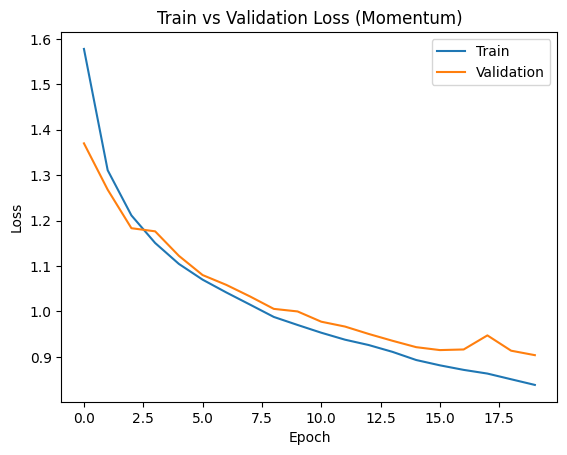

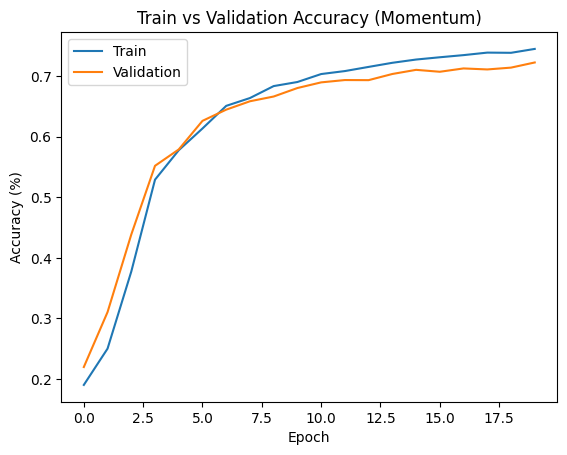

In [70]:
train_model_mom()

In [76]:
### FROM PARTS 1 & 2
# M2 test accuracy
M2_test_prediction = predict_M2(X_test).argmax(1)
M2_test_acc = (np.array(M2_test_prediction).flatten() == Y_test).sum()
M2_test_accuracy_percentage = 100*M2_test_acc/X_test.shape[0]

# M1 test accuracy
M1_test_prediction = predict_M1(X_test).argmax(1)
M1_test_acc = (np.array(M1_test_prediction).flatten() == Y_test).sum()
M1_test_accuracy_percentage = 100*M1_test_acc/X_test.shape[0]

# Base test accuracy
base_test_prediction = predict(X_test).argmax(1)
base_test_acc = (np.array(base_test_prediction).flatten() == Y_test).sum()
base_test_accuracy_percentage = 100*base_test_acc/X_test.shape[0]

### FROM PART 4
# Adam test accuracy
adam_test_prediction = predict_adam(X_test).argmax(1)
adam_test_acc = (np.array(adam_test_prediction).flatten() == Y_test).sum()
adam_test_accuracy_percentage = 100*adam_test_acc/X_test.shape[0]

# Momentum test accuracy
mom_test_prediction = predict_mom(X_test).argmax(1)
mom_test_acc = (np.array(mom_test_prediction).flatten() == Y_test).sum()
mom_test_accuracy_percentage = 100*mom_test_acc/X_test.shape[0]

# Printing results
print(f'Base test accuracy: {round(base_test_accuracy_percentage,2)}%')
print(f'M1 test accuracy: {round(M1_test_accuracy_percentage,2)}%')
print(f'M2 test accuracy: {round(M2_test_accuracy_percentage,2)}%')
print(f'Adam test accuracy: {round(adam_test_accuracy_percentage,2)}%')
print(f'Momentum test accuracy: {round(mom_test_accuracy_percentage,2)}%')

Base test accuracy: 19.37%
M1 test accuracy: 27.68%
M2 test accuracy: 59.3%
Adam test accuracy: 73.2%
Momentum test accuracy: 71.8%
